## Import libraries and csv

In [92]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file into a Pandas DataFrame with a header row

customers = pd.read_csv('/Users/Juan/Macbook/DA_files/Data Circle/customers.csv', header=0)
orders = pd.read_csv('/Users/Juan/Macbook/DA_files/Data Circle/orders.csv', header=0)
payments = pd.read_csv('/Users/Juan/Macbook/DA_files/Data Circle/payments.csv', header=0)

## 
## Check df and null values

In [93]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          100 non-null    int64 
 1   FIRST_NAME  100 non-null    object
 2   LAST_NAME   100 non-null    object
dtypes: int64(1), object(2)
memory usage: 2.5+ KB


In [94]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          99 non-null     int64 
 1   USER_ID     99 non-null     int64 
 2   ORDER_DATE  99 non-null     object
 3   STATUS      99 non-null     object
dtypes: int64(2), object(2)
memory usage: 3.2+ KB


In [95]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             120 non-null    int64 
 1   ORDERID        120 non-null    int64 
 2   PAYMENTMETHOD  120 non-null    object
 3   STATUS         120 non-null    object
 4   AMOUNT         120 non-null    int64 
 5   CREATED        120 non-null    object
dtypes: int64(3), object(3)
memory usage: 5.8+ KB


#### We realize there are no null-values and                                                                                                                                                                      that we should rename some of the column names for better understanding.

## 
## Rename columns

In [96]:
customers.rename(columns={'ID': 'CUSTOMER_ID'}, inplace=True)

In [97]:
orders.rename(columns={'ID': 'ORDER_ID', 'USER_ID': 'CUSTOMER_ID'}, inplace=True)

In [98]:
payments.rename(columns={'ID': 'PAYMENT_ID', 'ORDERID': 'ORDER_ID', 'PAYMENTMETHOD': 'PAYMENT_METHOD'}, inplace=True)

# 
# Df head( )
 

### CUSTOMERS

In [99]:
customers.head()

,CUSTOMER_ID,FIRST_NAME,LAST_NAME
0,1,Michael,P.
1,2,Shawn,M.
2,3,Kathleen,P.
3,4,Jimmy,C.
4,5,Katherine,R.


#### Basic table, we should have in mind that the last name is only the inicial
#### 

### ORDERS

In [100]:
orders.head()

,ORDER_ID,CUSTOMER_ID,ORDER_DATE,STATUS
0,1,1,2018-01-01,returned
1,2,3,2018-01-02,completed
2,3,94,2018-01-04,completed
3,4,50,2018-01-05,completed
4,5,64,2018-01-05,completed


#### One customer can have multiple orders, but not the other way around. Important to check STATUS when analyzing the whole df
#### 

### PAYMENTS

In [101]:
payments.head()

,PAYMENT_ID,ORDER_ID,PAYMENT_METHOD,STATUS,AMOUNT,CREATED
0,1,1,credit_card,success,1000,2018-01-01
1,2,2,credit_card,success,2000,2018-01-02
2,3,3,coupon,success,100,2018-01-04
3,4,4,coupon,success,2500,2018-01-05
4,5,5,bank_transfer,fail,1700,2018-01-05


#### Important to check STATUS when analyzing the whole df.
#### 

# ANALYSIS

### CUSTOMERS

In [102]:
# We check if someone have the same combination of first and last name

duplicated_values = customers[customers.duplicated(subset=['FIRST_NAME', 'LAST_NAME'])]

if len(duplicated_values) > 0:
    print('The following values are duplicated:')
    print(duplicated_values)
    
else:
    print('There are no duplicated values in first and lastname.')
    

There are no duplicated values in first and lastname.


### ORDERS

<Axes: >

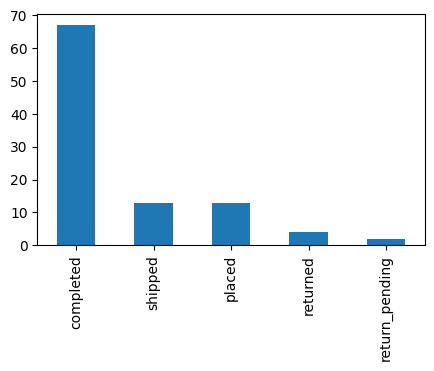

In [103]:
# count the occurrences of each distinct value in column B
value_counts = orders['STATUS'].value_counts()
value_counts.plot(kind = 'bar', figsize=(5, 3))

### PAYMENTS

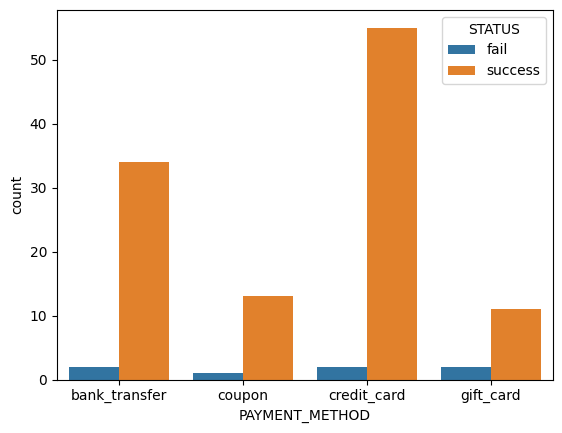

In [104]:
value_counts = payments.groupby(['STATUS', 'PAYMENT_METHOD']).size().reset_index(name='count')
sns.barplot(x='PAYMENT_METHOD', y='count', hue='STATUS', data=value_counts)
plt.show()


### We realize most of our sells are made with credit_card and bank_transfer
### 

### Connect db with SQLite

In [36]:
conn = sqlite3.connect('shop.db')
cur = conn.cursor()

In [6]:
#customers.to_sql('customers', conn, if_exists='replace', index=False)
#orders.to_sql('orders', conn, if_exists='replace', index=False)
#payments.to_sql('payments', conn, if_exists='replace', index=False)

# QUERYS

### Check which status and how many do we have

In [47]:
query = '''
SELECT o.status, p.status, count(*) FROM payments p
LEFT JOIN orders o on
o.ORDER_ID = p.ORDER_ID
group by p.status, o.status
'''

In [48]:
pd.read_sql_query(query, conn)

,STATUS,STATUS,count(*)
0,completed,fail,5
1,placed,fail,1
2,return_pending,fail,1
3,completed,success,76
4,placed,success,15
5,return_pending,success,2
6,returned,success,5
7,shipped,success,15


### Discover we have payments with a repeated order_id

In [108]:
query = '''
select p.* from (select order_id, count(*) as rep from payments
group by order_id) as sq
left join payments p 
on p.order_id = sq.order_id
where rep > 1
limit 9
               
'''

In [109]:
pd.read_sql_query(query, conn)

,PAYMENT_ID,ORDER_ID,PAYMENT_METHOD,STATUS,AMOUNT,CREATED
0,5,5,bank_transfer,fail,1700,2018-01-05
1,6,5,bank_transfer,success,1700,2018-01-05
2,10,9,gift_card,success,2300,2018-01-12
3,11,9,bank_transfer,success,0,2018-01-12
4,15,13,credit_card,fail,500,2018-01-17
5,16,13,bank_transfer,success,500,2018-01-17
6,17,13,bank_transfer,success,1400,2018-01-17
7,22,18,credit_card,success,500,2018-01-20
8,23,18,credit_card,success,800,2018-01-20


### Check sum of amounts where payment status = success

In [56]:
query = '''
select o.status, sum(amount) from payments p
left join orders o on
p.order_id = o.order_id
where p.status = 'success'
group by o.status
               
'''

In [57]:
pd.read_sql_query(query, conn)

,STATUS,sum(amount)
0,completed,110300
1,placed,28400
2,return_pending,3800
3,returned,4900
4,shipped,19800


### Check sum of amounts where payment status = fail

In [28]:
query = '''
select o.status, sum(amount) from payments p
left join orders o on
p.order_id = o.order_id
where p.status = 'fail'
group by o.status
               
'''

In [29]:
pd.read_sql_query(query, conn)

,STATUS,sum(amount)
0,completed,6100
1,placed,700
2,return_pending,2300


### Range of dates of our df

In [37]:
query = '''
select min(created), max(created) from payments
               
'''

In [38]:
pd.read_sql_query(query, conn)

,min(created),max(created)
0,2018-01-01,2018-04-09


### Amount of successfully sales, divided by month

In [106]:
query = '''
select month, status2, sum(amount) 
from(select *, o.status as status2, strftime('%m', p.created) AS month from payments p
    left join orders o on
    p.order_id = o.order_id
    where p.status = 'success') as sq
group by month, status2

               
'''

In [107]:
pd.read_sql_query(query, conn)

,month,status2,sum(amount)
0,01,completed,42400
1,01,return_pending,2300
2,01,returned,4900
3,02,completed,40000
4,02,return_pending,1500
5,03,completed,27900
6,03,placed,14500
7,03,shipped,19800
8,04,placed,13900


In [98]:
query = '''
select *, strftime('%m', p.created) AS month from payments p
    left join orders o on
    p.order_id = o.order_id
    where p.status = 'success'
'''

In [99]:
pd.read_sql_query(query, conn)

,PAYMENT_ID,ORDER_ID,PAYMENT_METHOD,STATUS,AMOUNT,CREATED,ORDER_ID,CUSTOMER_ID,ORDER_DATE,STATUS,month
0,1,1,credit_card,success,1000,2018-01-01,1,1,2018-01-01,returned,01
1,2,2,credit_card,success,2000,2018-01-02,2,3,2018-01-02,completed,01
2,3,3,coupon,success,100,2018-01-04,3,94,2018-01-04,completed,01
3,4,4,coupon,success,2500,2018-01-05,4,50,2018-01-05,completed,01
4,6,5,bank_transfer,success,1700,2018-01-05,5,64,2018-01-05,completed,01
...,...,...,...,...,...,...,...,...,...,...,...
108,116,95,coupon,success,2400,2018-04-04,95,27,2018-04-04,placed,04
109,117,96,gift_card,success,1700,2018-04-06,96,90,2018-04-06,placed,04
110,118,97,bank_transfer,success,1400,2018-04-07,97,89,2018-04-07,placed,04
111,119,98,bank_transfer,success,1000,2018-04-07,98,41,2018-04-07,placed,04


In [39]:
query = '''
select status, count(*) from orders
group by status
'''

In [40]:
pd.read_sql_query(query, conn)

,STATUS,count(*)
0,completed,67
1,placed,13
2,return_pending,2
3,returned,4
4,shipped,13
